In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage, AnnotationBbox)
import sys
from pylab import *
import os
import urllib.request
import itertools
import seaborn as sns
import numpy as np
from adjustText import adjust_text

In [2]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
#pd.set_option('display.max_colwidth', None)

pd.options.mode.chained_assignment = None

In [3]:
COLORS = {'ARI':'#97233F','ATL':'#A71930','BAL':'#241773','BUF':'#00338D','CAR':'#0085CA','CHI':'#00143F',
          'CIN':'#FB4F14','CLE':'#FB4F14','DAL':'#B0B7BC','DEN':'#002244','DET':'#046EB4','GB':'#24423C',
          'HOU':'#C9243F','IND':'#003D79','JAX':'#136677','KC':'#CA2430','LA':'#002147','LAC':'#2072BA',
          'LV':'#C4C9CC','MIA':'#0091A0','MIN':'#4F2E84','NE':'#0A2342','NO':'#A08A58','NYG':'#192E6C',
          'NYJ':'#203731','PHI':'#014A53','PIT':'#FFC20E','SEA':'#7AC142','SF':'#C9243F','TB':'#D40909',
          'TEN':'#4095D1','WAS':'#FFC20F'}

In [4]:
YEAR = 2020
data = pd.read_csv('https://github.com/guga31bb/nflfastR-data/blob/master/data/' \
                         'play_by_play_' + str(YEAR) + '.csv.gz?raw=True',
                         compression='gzip', low_memory=False)

In [5]:
#remove deprecated columns
data.drop(['passer_player_name', 'passer_player_id',
           'rusher_player_name', 'rusher_player_id',
           'receiver_player_name', 'receiver_player_id'],
          axis=1, inplace=True)

In [6]:
#remove plays that are not penalties, passes, or runs or have null epa
data = data.loc[(data.play_type.isin(['no_play','pass','run'])) & (data.epa.isna()==False)]

In [7]:
#make sure QB scrambles are labeled appropriately
data.play_type.loc[data['pass']==1] = 'pass'
data.play_type.loc[data.rush==1] = 'run'

In [8]:
#clean up index after data clean up
data.reset_index(drop=True, inplace=True)

In [ ]:
#get current week for qualifying data
currentweek = data['week'].max()
#qualifying number of plays
qualify_val = currentweek*20

In [9]:
#group by without making it the index!
qbs = data.groupby(['passer', 'posteam'], as_index=False).agg({'qb_epa':'mean',
                                                               'cpoe':'mean',
                                                               'play_id':'count'})

In [10]:
qbs.sort_values('qb_epa', ascending=False, inplace=True)

#round data!
qbs = qbs.round(2)

#rename columns easily!
qbs.columns = ['Player', 'Team', 'EPA per Dropback', 'CPOE', 'Dropbacks']

In [11]:
qbs = qbs.loc[(qbs['Dropbacks'] > qualify_val)]

In [12]:
#Add team colors to dataframe
#maps using Team abbrev matching dict key
qbs['color'] = qbs['Team'].map(COLORS)
#qbs

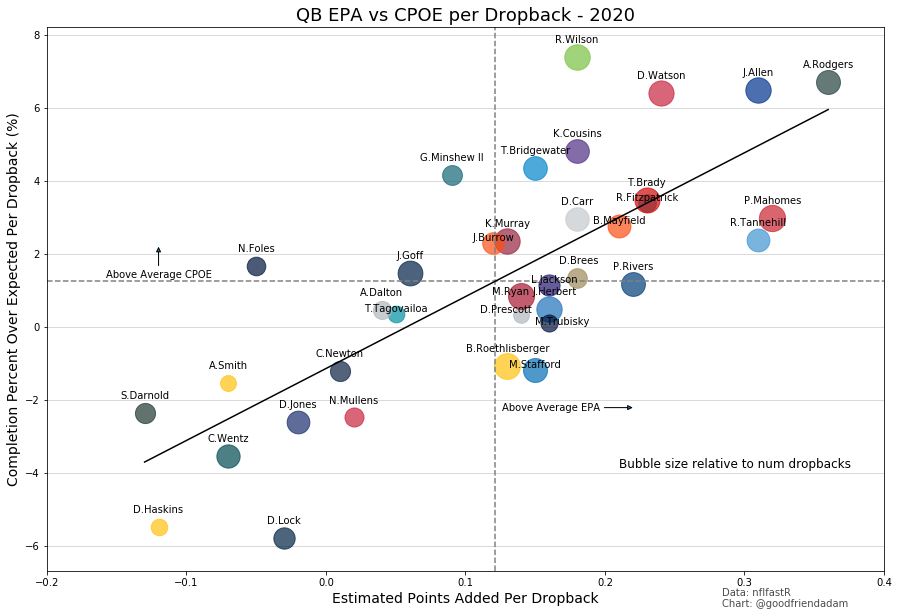

In [31]:
#create figure
fig, ax = plt.subplots(figsize=(15,10))

#make scatter plot with data

#add data to chart
for player, row in qbs.iterrows():
    plt.scatter(row['EPA per Dropback'], row['CPOE'], label=player, c=row['color'], alpha=.7, s=(row['Dropbacks']))
#    plt.text(row['CPOE']-0.3, row['EPA per Dropback']+.01, row['Player'])
    #plt.text(x0, y0, frameon=False, fontsize=4)

#append names and allows to adjust below
texts = []
for x, y, s in zip(qbs['EPA per Dropback'], qbs['CPOE'], qbs['Player']):
    texts.append(plt.text(x, y+.3, s))
    
#add grid
ax.grid(zorder=0, alpha=.6, axis='y')
ax.set_axisbelow(True)

#set means
cpoe_mean = qbs['CPOE'].mean()
epa_mean = qbs['EPA per Dropback'].mean()

#set average cpoe
ax.axvline(x=epa_mean, linestyle='--', color='grey')

#set average epa
ax.axhline(y=cpoe_mean, linestyle='--', color='grey')
             
#plot fit line
pfit = np.polyfit(qbs['EPA per Dropback'], qbs['CPOE'], 1)
trend_line_model = np.poly1d(pfit)
plt.plot(qbs['EPA per Dropback'], trend_line_model(qbs['EPA per Dropback']), linestyle="-", c='black') 

#League average line label for CPOE
ax.annotate('Above Average CPOE', xy=(-0.12, cpoe_mean+1), xytext=(-0.12, cpoe_mean+.1),
            arrowprops={'arrowstyle': '-|>'}, ha='center', color='black', fontsize=10)

#League average line label for EPA
ax.annotate('Above Average EPA', xy=(epa_mean+.1, -2.2), xytext=(epa_mean+.005, -2.2),
            arrowprops={'arrowstyle': '-|>'},  va='center', color='black', fontsize=10)

#add labels and text
ax.set_xlabel('Estimated Points Added Per Dropback', fontsize=14)
ax.set_ylabel('Completion Percent Over Expected Per Dropback (%)', fontsize=14)
ax.set_title('QB EPA vs CPOE per Dropback - 2020', fontsize=18)
ax.set_xlim(-0.2, 0.4)
ax.text(0.21, -3.85, 'Bubble size relative to num dropbacks', fontsize=12, color='black')
plt.figtext(.75, 0.09,'Data: nflfastR',fontsize=10, alpha=.7)
plt.figtext(.75, 0.075,'Chart: @goodfriendadam',fontsize=10, alpha=.7)

#adjust name spacing so no overlaps
adjust_text(texts, autoalign='y',
            only_move={'points':'y', 'text':'xy'})#, arrowprops=dict(arrowstyle='fancy', color='black'))

plt.savefig(os.getcwd() + '\\output\\qbepacpoe.png',dpi=400)

In [14]:
#cols = data.columns.tolist()
#cols